# Customization Case:Simple Linear Function Fitting

[![View Source On Gitee](https://gitee.com/mindspore/docs/raw/tutorials-develop/resource/_static/logo_source_en.png)](https://gitee.com/mindspore/docs/blob/tutorials-develop/tutorials/source_en/beginner/quick_start.ipynb)

MindSpore provides users with three different levels of API: high-level, intermediate-level, and low-level, and the details are described in the [Basic Introduction - Hierarchical Content section](https://www.mindspore.cn/tutorials/en/master/index.html).

In order to facilitate the control of the network execution process, MindSpore provides a high-order training and inference interface `mindspore.Model`, which trains and infers the network by specifying the neural network model to be trained and common training settings, and calls the `train` and `eval` methods. At the same time, if you want to personalize a specific module, you can also call the corresponding low-level interface to define the training process of the network.

This chapter will use the low-level and intermediate-level APIs provided by MindSpore to fit linear functions:

$$f(x) = 2x + 3  \tag {1}$$

Before initializing the network, you need to configure the `context` parameters to control the policies executed by the program, such as configuring static graph or dynamic graph mode, configuring the hardware environment in which the network runs, and so on. This chapter will introduce configuration information and use low-level and medium-level APIs to customize loss functions, optimizers, training processes, Metrics, and custom validation process modules using low-level and intermediate-level APIs provided by MindSpore.

## Configuration Information

Before initializing the network, you need to configure the `context` parameter to control the policies executed by the program, such as configuring static graph or dynamic graph mode, configuring the hardware environment in which the network runs, and so on. Before initializing the network, you need to configure the `content` parameter to control the policy of program execution, and this section mainly describes execution mode management and hardware management.

### Execution Mode

MindSpore supports both Graph and PyNative modes of operation. The Graph mode is the default mode for MindSpore, while the PyNative mode is used for purposes such as debugging.

- Graph mode (static graph mode): The neural network model is compiled into a whole graph and then sent to hardware for execution. This mode leverages techniques such as graph optimization to improve operational performance while facilitating scale deployments and cross-platform operations.

- PyNative mode ((dynamic graph mode): The individual operators in the neural network are sent one by one to the hardware for execution. This mode is convenient for users to write code and debug the neural network model.)


#### Mode Choice

By configuring the context parameter, you can control the mode in which the program runs. The main differences between the Graph and PyNative modes are:

- Usage scenario: The Graph mode needs to build the network structure first, and then the framework does the whole map optimization and execution, which is more suitable for scenarios where the network is fixed without changes, and high performance is required. The PyNative mode, on the other hand, executes operators line by line, supports the execution of single operators, ordinary functions and networks, and the operation of gradients alone.

- Network execution: The Graph and PyNative modes have the same precision effect when performing the same network and operators. Since graph mode uses graph optimization, calculation graph sinking and other techniques, graph mode execution network performance and efficiency is higher.

- Code debugging: In script development and network process debugging, it is recommended to use PyNative mode for debugging. In the PyNative mode, you can easily set breakpoints, obtain intermediate results of network execution, and debug the network by pdb. The Graph mode cannot set a breakpoint, only specify the operator to print, and then view the output after the network execution is completed.

When using the Graph mode, set the running mode in the context to `GRAPH_MODE`, you need to use `nn. Cell` class, and write execution code in the `construst` function, or call `@ms_function` decorator.

#### Mode Switch

MindSpore provides a unified encoding method for static and dynamic diagrams, which greatly increases the compatibility of static diagrams and dynamic diagrams, and the users do not need to develop multiple sets of code, and can switch static diagram/dynamic diagram mode with only one line of code. When switching modes, pay attention to the [constraints](https://www.mindspore.cn/docs/note/en/master/static_graph_syntax_support.html) of the target mode.

> For example, the PyNative mode does not support data sinking, etc.

Set the running mode to the dynamic graph mode:

In [ ]:
from mindspore import context

context.set_context(mode=context.PYNATIVE_MODE)

When MindSpore is in the static graph mode, it can switch to dynamic graph mode by `context.set_context (mode=context. PYNATIVE_MODE)`; similarly, when MindSpore is in dynamic graph mode, it can switch to static graph mode by `context.set_context (mode=context. GRAPH_MODE)`.

In [ ]:
context.set_context(mode=context.GRAPH_MODE)

### Hardware Management

The hardware management part mainly includes two parameters: `device_target` and `device_id`.

- `device_target`: the target device to be run supports `Ascend`, `GPU` and `CPU`, and can be set according to the actual environment conditions.

- `device_id`: indicates the target device ID, whose value is in the range of [0, `device_num_per_host` - 1]. `device_num_per_host` represents the total number of devices of the server, and the value of the `device_num_per_host` cannot exceed 4096. `device_id` defaults to 0. In the case of non-distributed mode execution, in order to avoid the use of device conflicts, the device ID of the program execution can be determined by setting the `device_id`.

The code examples are as follow:

```Python
from mindspore import context

context.set_context(device_target="Ascend", device_id=6)
```

## Generating the Dataset

Define dataset generation functions `get_data` to generate a training dataset and a test dataset.

Since the linear data is fitted, assuming that the objective function to be fitted is: $f(x)=2x+3$, the training dataset we need should be randomly distributed around the function, which is generated in the way $f(x)=2x+3+noise$. `noise` is a random value that follows the standard normal distribution law.

In [ ]:
import numpy as np

def get_data(num, w=2.0, b=3.0):
    for _ in range(num):
        x = np.random.uniform(-10.0, 10.0)
        noise = np.random.normal(0, 1)
        y = x * w + b + noise
        yield np.array([x]).astype(np.float32), np.array([y]).astype(np.float32)

Use `get_data` to generate 50 groups of test data and visualize them.

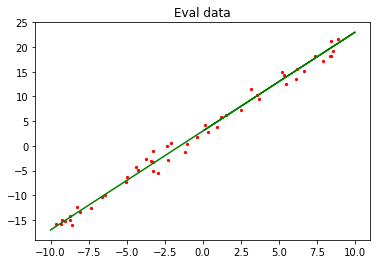

In [3]:
import matplotlib.pyplot as plt

train_data = list(get_data(50))
x_target_label = np.array([-10, 10, 0.1])
y_target_label = x_target_label * 2 + 3
x_eval_label, y_eval_label = zip(*train_data)

plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_target_label, y_target_label, color="green")
plt.title("Eval data")
plt.show()

In the preceding figure, the green line indicates the objective function, and the red points indicate the verification data `train_data`.

## Loading the dataset

Load the dataset and process the data.

- `ds.GeneratorDataset`: converts the generated data into a MindSpore dataset and saves the x and y values of the generated data to arrays of `data` and `label`.
- `batch`: combines `batch_size` pieces of data into a batch.
- `repeat`: multiplies the number of datasets.

In [4]:
from mindspore import dataset as ds

def create_dataset(num_data, batch_size=16, repeat_size=1):
    input_data = ds.GeneratorDataset(list(get_data(num_data)), column_names=['data', 'label'])
    input_data = input_data.batch(batch_size, drop_remainder=True)
    input_data = input_data.repeat(repeat_size)
    return input_data

Use the dataset argumentation function to generate training data and the resulting 1600 data is enhanced by defining `create_dataset` into 100 sets of 16x1 datasets.

In [5]:
data_number = 1600
batch_number = 16
repeat_number = 1

ds_train = create_dataset(data_number, batch_size=batch_number, repeat_size=repeat_number)
print("The dataset size of ds_train:", ds_train.get_dataset_size())
step_size = ds_train.get_dataset_size()
dict_datasets = next(ds_train.create_dict_iterator())

print(dict_datasets.keys())
print("The x label value shape:", dict_datasets["data"].shape)
print("The y label value shape:", dict_datasets["label"].shape)

The dataset size of ds_train: 100
dict_keys(['data', 'label'])
The x label value shape: (16, 1)
The y label value shape: (16, 1)


## Defining the Linear Neural Network Model

The `mindspore.nn` class is the base class for building all networks and is also the basic unit of the network. When users need to customize the network, they can inherit `nn. Cell` class, and override the `init` method and the `construst` method. The `mindspore.ops` module provides an implementation of the base operator, and the `nn.Cell` module implements further encapsulation of the base operator, allowing users to flexibly use different operators as needed.

The following example uses `nn. Cell` builds a simple fully connected network with sample snippet code for subsequent customizations.

In MindSpore, use `nn.Dense` to generate single data input and the linear function model output by the single data:

$$f(x)=wx+b\tag{1}$$

Use the Normal operator to randomly initialize the weights $w$ and $b$.

In [6]:
from mindspore import nn
from mindspore.common.initializer import Normal

class LinearNet(nn.Cell):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.fc = nn.Dense(1, 1, Normal(0.02), Normal(0.02))

    def construct(self, x):
        x = self.fc(x)
        return x

After the network model is initialized, the initialized network function and the training dataset are visualized to understand the model functions before fitting.

In [7]:
from mindspore import Tensor

# Initialize the linear regression network
net = LinearNet()
# Get the network parameters w and b before training
model_params = net.trainable_params()

x_model_label = np.array([-10, 10, 0.1])
y_model_label = (x_model_label * Tensor(model_params[0]).asnumpy()[0][0] +
                 Tensor(model_params[1]).asnumpy()[0])

plt.axis([-10, 10, -20, 25])
plt.scatter(x_eval_label, y_eval_label, color="red", s=5)
plt.plot(x_model_label, y_model_label, color="blue")
plt.plot(x_target_label, y_target_label, color="green")
plt.show()

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[-0.0052068]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [-0.02897885]


## Customizing the Loss Function

The Loss Function is used to measure the degree to which the predicted value differs from the true value. In deep learning, model training is the process of narrowing the loss function value by constantly iterating, so the choice of the loss function during model training is very important, and defining a good loss function can help the loss function value converge faster and achieve better accuracy.

[mindspore.nn](https://www.mindspore.cn/docs/api/en/master/api_python/mindspore.nn.html#id13) provides a number of common loss functions for users to choose from, and also allows users to customize loss functions as needed.

When you customize the loss function class, you can inherit both the base class of the network `nn. Cell`, which can also inherit the base class of the loss function `nn. LossBase`. `nn. LossBase` provides `get_loss` method based on `nn.Cell` to sum or mean the loss values by using the `reduction` parameter to output a scalar. The mean absolute error loss function (MAE) will be defined by using the method of inheriting LosBase, and the formula of the MAE algorithm is as follows:

$$loss= \frac{1}{m}\sum_{i=1}^m\lvert y_i-f(x_i) \rvert $$

In the above equation, $f(x)$ is the predicted value, $y$ is the sample true value, and $loss$ is the average of the distance between the predicted value and the true value.

When using the LossBase method to customize the loss function, you need to override the `__init__` method and the `construst` method, and use the `get_loss` method to calculate the loss. The sample code is as follows:

In [9]:
from mindspore import nn, ops

class MyMAELoss(nn.LossBase):
    """Define Loss"""
    def __init__(self, reduction="mean"):
        super(MyMAELoss, self).__init__(reduction)
        self.abs = ops.Abs()

    def construct(self, predict, target):
        x = self.abs(predict - target)
        return self.get_loss(x)

## Customizing the Optimizer

The optimizer is used to calculate and update network parameters during model training, and the appropriate optimizer can effectively reduce the training time and improve model performance.

[mindspore.nn](https://www.mindspore.cn/docs/api/en/master/api_python/mindspore.nn.html#id14) provides a number of general-purpose optimizers for users to choose, while also allowing users to customize the optimizer as needed.

When customizing the optimizer, you can inherit the optimizer base class `nn. Optimizer`, overrides `__init__` methods and `construct` methods implement updates to parameters.

The following example implements the custom optimizer Momentum:

$$ v_{t+1} = v_t×u+grad $$

SGD algorithm with momentum:

$$p_{t+1} = p_t - lr*v_{t+1}$$

Using the SGD algorithm for Nesterov momentum:

$$p_{t+1} = p_t-(grad+v_{t+1}*u)×lr $$

where grad, lr, p, v, and u respectively represent gradients, learning rates, parameters, moments, and momentums.

In [10]:
from mindspore import Tensor, Parameter
from mindspore import nn, ops
from mindspore import dtype as mstype

class MyMomentum(nn.Optimizer):
    """Define the optimizer"""
    def __init__(self, params, learning_rate, momentum=0.9, use_nesterov=False):
        super(MyMomentum, self).__init__(learning_rate, params)
        self.momentum = Parameter(Tensor(momentum, mstype.float32), name="momentum")
        self.use_nesterov = use_nesterov
        self.moments = self.parameters.clone(prefix="moments", init="zeros")
        self.assign = ops.Assign()

    def construct(self, gradients):
        """The construct input is a gradient, which automatically passes in gradients during training"""
        lr = self.get_lr()
        # The weight parameter to be updated
        params = self.parameters
        for i in range(len(params)):
            # Update moments value
            self.assign(self.moments[i], self.moments[i] * self.momentum + gradients[i])
            if self.use_nesterov:
                # Using the SGD algorithm for Nesterov momentum:
                update = params[i] - (self.moments[i] * self.momentum + gradients[i]) * lr
            else:
                # SGD algorithm with momentum
                update = params[i] - self.moments[i] * lr
            # Update the params value as update value
            self.assign(params[i], update)
        return params

## Customizing the Training Process

`mindspore. Model` provides the interface of `train` and `eval` to facilitate users to use during training, but this interface cannot be applied to all scenarios, such as multi-data and multi-label scenarios, where the users need to define their own training process. This section uses linear regression examples to briefly describe the custom training process. First define the loss network, connecting the forward network to the loss function, and then define the training process, which generally inherits `nn.TrainOneStepCell`. `nn.TrainOneStepCell` encapsulates the loss network and optimizer to implement a backpropagation network and to update the weight parameters.

### Defining the Loss Function

Define the loss network `MyWithLossCell`, which connects the forward network to the loss function.

In [11]:
class MyWithLossCell(nn.Cell):
    """Define the loss function"""

    def __init__(self, backbone, loss_fn):
        """The forward network and the loss function are passed in as parameters when instantiated"""
        super(MyWithLossCell, self).__init__(auto_prefix=False)
        self.backbone = backbone
        self.loss_fn = loss_fn

    def construct(self, data, label):
        """Connecting the forward network and the loss function"""
        out = self.backbone(data)
        return self.loss_fn(out, label)

    def backbone_network(self):
        """The backbone network to be encapsulated"""
        return self.backbone

### Defining the Training Process

Define the training process `MyTrainStep`, which inherits `nn.TrainOneStepCell`. `nn.TrainOneStepCell` encapsulates the loss network and optimizer, performs the acquisition of gradient by `ops.GradOperation` operator when performing training and updates the weights through the optimizer.

In [12]:
class MyTrainStep(nn.TrainOneStepCell):
    """Define the training process"""

    def __init__(self, network, optimizer):
        """Parameter initialization"""
        super(MyTrainStep, self).__init__(network, optimizer)
        self.grad = ops.GradOperation(get_by_list=True)

    def construct(self, data, label):
        """Construct the training process"""
        weights = self.weights
        loss = self.network(data, label)
        grads = self.grad(self.network, weights)(data, label)
        return loss, self.optimizer(grads)

### Defining the Drawing Function

Define drawing function `plot_model_and_datasets` plot test data, the objective function, and the network model fitting function, and view the loss value.

In [13]:
import matplotlib.pyplot as plt
import time


def plot_model_and_datasets(net, data, loss):
    weight = net.trainable_params()[0]
    bias = net.trainable_params()[1]
    x = np.arange(-10, 10, 0.1)
    y = x * Tensor(weight).asnumpy()[0][0] + Tensor(bias).asnumpy()[0]
    x1, y1 = zip(*data)
    x_target = x
    y_target = x_target * 2 + 3

    plt.axis([-11, 11, -20, 25])
    # Raw data
    plt.scatter(x1, y1, color="red", s=5)
    # Predicted data
    plt.plot(x, y, color="blue")
    # Fitting function
    plt.plot(x_target, y_target, color="green")
    # Print the loss value
    plt.title(f"Loss:{loss}")

    plt.show()
    time.sleep(0.2)
    display.clear_output(wait=True)

### Executing the Training

Use the training data `ds_train` train the training network `train_net` and visualize the training process.

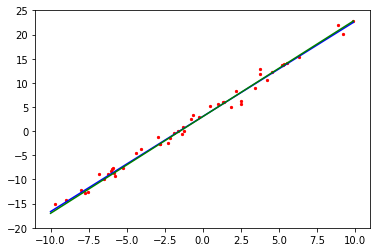

[Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True), Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True)]
Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[1.9679272]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [3.0316615]


In [14]:
from IPython import display

# Loss function
loss_func = MyMAELoss()
# Optimizer
opt = MyMomentum(net.trainable_params(), 0.01)
# Construct the loss network
net_with_criterion = MyWithLossCell(net, loss_func)
# Construct the training network
train_net = MyTrainStep(net_with_criterion, opt)

for data in ds_train.create_dict_iterator():
    # Perform training and update the weights
    train_net(data['data'], data['label'])
    # Loss values
    loss = net_with_criterion(data['data'], data['label'])
    # Visualize the training process
    plot_model_and_datasets(train_net, train_data, loss)

## Customizing evaluation metrics

When the training task is over, it is often necessary to evaluate the metrics evaluation function to evaluate the quality of the model. The metrics are commonly evaluation index confusion matrix, Accuracy, Precision, Recall, etc.

The [mindspore.nn](https://www.mindspore.cn/docs/api/en/master/api_python/mindspore.nn.html#id16) module provides common evaluation functions, and users can also define their own evaluation indicators as needed. Customizing Metrics functions need to inherit from the `nn.Metric` parent class and reimplement the `clear`, `update`, and `eval` methods in the parent class. The average absolute error (MAE) algorithm is shown in the following equation, and the following is an example of a simple MAE to introduce these three functions and how to use them.

$$ MAE=\frac{1}{n}\sum_{i=1}^n\lvert ypred_i - y_i \rvert$$

- `clear`: Initialize the relevant internal parameters.
- `update`: Receive network prediction outputs and labels, calculate errors, and update internal evaluation results. Generally after each step is calculated, the statistical values are updated.
- `eval`: Calculate the final assessment result, generally at the end of an epoch.

In [15]:
class MyMAE(nn.Metric):
    """Define metric"""

    def __init__(self):
        super(MyMAE, self).__init__()
        self.clear()

    def clear(self):
        """Initialize the variables abs_error_sum and samples_num"""
        self.abs_error_sum = 0
        self.samples_num = 0

    def update(self, *inputs):
        """Update abs_error_sum and samples_num"""
        if len(inputs) != 2:
            raise ValueError('Mean absolute error need 2 inputs (y_pred, y), but got {}'.format(len(inputs)))
        # Convert Tensor to NumPy for subsequent calculations
        y_pred = inputs[0].asnumpy()
        y = inputs[1].asnumpy()
        # Calculates the absolute error between the predicted value and the true value
        error_abs = np.abs(y.reshape(y_pred.shape) - y_pred)
        self.abs_error_sum += error_abs.sum()
        # The total number of the samples
        self.samples_num += y.shape[0]

    def eval(self):
        """Calculate the final assessment results"""
        if self.samples_num == 0:
            raise RuntimeError('Total samples num must not be 0.')
        return self.abs_error_sum / self.samples_num

fc.weight : [[1.9679272]]
fc.bias : [3.0316615]


## Customizing the validation process

The mindspore.nn module provides an evaluation network wrapper function [nn.WithEvalCell](https://www.mindspore.cn/docs/api/en/master/api_python/nn/mindspore.nn.WithEvalCell.html#mindspore.nn.WithEvalCell), because `nn.WithEvalCell` has only two input `data` and `label`, which is not suitable for multi-data or multi-label scenarios, so it is necessary to customize the evaluation network. For custom evaluation networks in multi-label scenarios, please refer to the [Custom Evaluation and Training section](https://www.mindspore.cn/tutorials/zh-CN/master/advance/train/train_eval.html#Customizingtheevaluationnetwork).

The following example implements a simple customization evaluation network `MyWithEvalCell`, entering inputting data `data` and `label`:

In [ ]:
class MyWithEvalCell(nn.Cell):
    """Define the validation process"""

    def __init__(self, network):
        super(MyWithEvalCell, self).__init__(auto_prefix=False)
        self.network = network

    def construct(self, data, label):
        outputs = self.network(data)
        return outputs, label

Perform inference and evaluation:

In [ ]:
data_number = 160
batch_number = 16
repeat_number = 1
# Obtain the validation data
ds_eval = create_dataset(data_number, batch_size=batch_number, repeat_size=repeat_number)
# Define the evaluation network
eval_net = MyWithEvalCell(net)
eval_net.set_train(False)
# Define the evaluation metrics
mae = MyMAE()

# Execute the inference process
for data in ds_eval.create_dict_iterator():
    output, eval_y = eval_net(data['data'], data['label'])
    mae.update(output, eval_y)

mae_result = mae.eval()
print("MAE: ", mae_result)

Output the evaluation error, and MAE and the model on the training set effect is about the same.

## Saving and Exporting the Model

Save the above trained model parameters to the CheckPoint (ckpt) file, and then export the CheckPoint file as a MindIR format file for cross-platform inference.

In [ ]:
import numpy as np
from mindspore import save_checkpoint, load_checkpoint, export

# Save the model parameters in a ckpt file
save_checkpoint(net, "./linear.ckpt")
# Save the model parameters in the param_dict dictionary
param_dict = load_checkpoint("./linear.ckpt")
# View the model parameters
for param in param_dict:
    print(param, ":", param_dict[param].asnumpy())

# Define a linear network
net1 = LinearNet()
input_np = np.random.uniform(0.0, 1.0, size=[1, 1]).astype(np.float32)
export(net1, Tensor(input_np), file_name='linear', file_format='MINDIR')